In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt

from datasets import get_retail_store_minnesota
from utilis import *

from matplotlib import pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# **Traveling Salesman Problem**

>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?".


Travelling Salesman Problem (TSP) aims to find the optimal solution which has the minimal sum of visiting distances and contains only a single tour covering all cities. TSP is a NP-hard problem in Optimization study (specifically in Combinatorial Optimization). And the solutions of TSP have been commonly applied to Vehicle Routing ("What is the optimal set of routes for a fleet of vehicles to traverse in order to deliver to a given set of customers?) and other spatial analytics usecases. 

## **Definition of TSP**

Given Graph $G(V, E)$
- No self-loop in $G$
- $V$: the set of all cities ($i$=1 ... N )
- $E$: the set of roads between cities
- $c_{ij}$: the distance between city $i$ and city $j$
- $\begin{equation}
  x_{ij}=\left\{
  \begin{array}{@{}ll@{}}
    1, & \text{if}\ the\ solution\ travels\ from\ city\ i\  to\ city\ j\\
    0, & \text{otherwise}
  \end{array}\right.
\end{equation} $
-  $u$:   $u_i$ = $t$,  if city i is visited in step t (i, t = 1, 2, ..., n)


**Target**

$$min\sum_{i=1}^{N}\sum_{j\neq i, j=1}^{N}c_{ij}x_{ij}\\
s.t.\\
\sum_{i=1}^{N}x_{ij}=1 \quad \forall j\in V   \\
\sum_{j=1}^{N}x_{ij}=1 \quad \forall i\in V  \\
u_{i} \in \mathbb{Z}\quad i=1 ... N \\
u_i - u_j + Nx_{ij} \leq N-1 \quad \forall\ i,\ j\in V,\ i\neq j,\ i\neq 1,\ j\neq 1\\
\forall u_{j} \geq 0\\
\forall x_{ij} =0\ or\ 1$$


The restrictions make sure each city is arrived at from exactly one other city and from each city there is a departure to exactly one other city. Also they enforce that there is only a single tour covering all cities, and not two or more disjointed tours that only collectively cover all cities 

## **Algorithms**

In general, there are two types of algorithms to address TSP:
- Exact Algorithms
    - Brute Force $O(n!)$
    - Dynamic Programming $O(n^22^n)$
    - ...
- Approximation Algorithms
    - Christofides Algorithm
    - Simulated Annealing
    - Ant Colony Optimizatiom
    - ...
    
Generally speaking, exact algorithms can reach the best solution but take longer than expected runtime. Considering the time constraint, approximation algorithms are more commonly used even though the solution is not gloabl optimal. The following example shows how to solve TSP. 


## **Example**

We have the location of each Target stores (or any other retailer) in US. Suppose a manager wants to inspect all 73 store in Minnesota, the company's home state, what's the best route with the shortest distance? 


### **Data**

In [2]:
data = get_retail_store_minnesota()
data['store_id'] = data['store_id'].apply(lambda x: str(int(x)))

In [3]:
# lat/lng pairs (e.g.[[47.209549, -93.527193], ...])
latlng = [[store.y, store.x] for store in data['the_geom']]
# lng/lat pairs (e.g.[[-93.527193, 47.209549], ...])
lnglat = [[store.x, store.y] for store in data['the_geom']]

# id: lat/lng dictionary (e.g.{'100': [47.209549, -93.527193], ...})
latlng_dict = {store[1]['store_id']: [store[1]['the_geom'].y, store[1]['the_geom'].x] for store in data.iterrows()}
# id: lng/lat dictionary (e.g.{'100': [-93.527193, 47.209549], ...})
lnglat_dict = {store[1]['store_id']: [store[1]['the_geom'].x, store[1]['the_geom'].y] for store in data.iterrows()}

In [4]:
from cartoframes.viz import Layer, basic_style, color_category_legend, formula_widget

Layer(data, 
      basic_style(size = 10), 
      legends=color_category_legend(title = 'Retail Store Locations'),
      widgets=[formula_widget('count', 
                              title='Number of Retail Stores', 
                              description='Minnesota')]
     )

### Method 1: **Christofides Method**


```markdown
1. Create a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T. 
3. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting).
```

<br/>

**Run `n=100` iterations of Christofides Method, then find the shortest path**, 

The length of the shortest path: 2071464.35058948 m


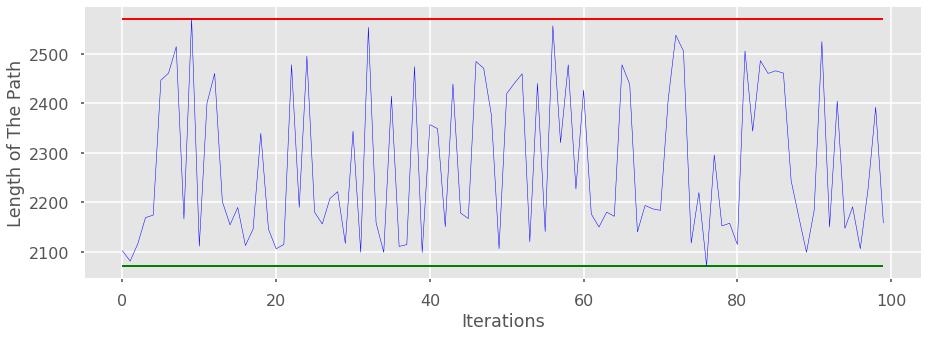

In [5]:
n = 100
tests = [christofides(latlng) for _ in range(n)]
length = [_[6] for _ in tests]  

# the following plot shows length of path of each iteration run. 
f, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(length, color='blue', linewidth=0.5)
ax.hlines(y=min(length), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max(length), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path')

tsp_result = tests[np.argmin(length)]
print(f'The length of the shortest path: {min(length)*1000} m')

<br/>

**The Following part shows how christofides algorithm works step by step**

#### 1. **Complete Graph (G)**

In [6]:
from cartoframes.viz import Map

complete_graph = pd.DataFrame([LineString(store) for store in combinations(lnglat, 2)], columns=['geometry'])
map1 = Map(Layer(complete_graph,
             geom_col = 'geometry',
             style = basic_style(size = 0.2, color = 'red', opacity = 0.3), 
             legends=color_category_legend(title = 'Step 1: Complete Graph'),
             widgets=[formula_widget('count', 
                              title='Number of Edges', 
                              description='in Complete Graph (G)')]
     ))
map1

#### 2. **Minimum Spanning Tree (T)**

In [7]:
minimum_spanning_tree = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[1]], columns=['geometry'])
map2 = Map(layers=[
    Layer(complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.5, color = 'red', opacity = 0.1), 
          widgets = [formula_widget('count', 
                                    title='Number of Edges', 
                                    description='in Complete Graph (G)')]),
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3), 
          legends = color_category_legend(title = 'Step 2: Minimum Spanning Tree (T)'),
          widgets = [formula_widget('count', 
                                    title='Number of Edges', 
                                    description='in Minimum Spanning Tree (T)')])],
    basemap = basemaps.voyager)
map2

#### 3. **Vertices with odd degree (O)**

In [8]:
vertices_odd_degree = pd.DataFrame([Point(*lnglat[store_id]) for store_id in tsp_result[2]], columns=['geometry'])
map3 = Map(layers=[
    Layer(complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.2, color = 'red', opacity = 0.1)), 
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3)), 
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'yellow'),
          legends = color_category_legend(title = 'Step 3: Vertices with odd degree (O)'),
          widgets = [formula_widget('count', title='Number of Vertices with Odd Degrees (O)', description='in Minimum Spanning Tree (T)')])
    ],
    basemap = basemaps.voyager)
map3

#### 4. **Form the subgraph G' of G using only the vertices of O (G')**

In [9]:
sub_complete_graph = pd.DataFrame([LineString(pair) for pair in combinations([list(lnglat)[i] for i in tsp_result[2]], 2)], columns=['geometry'])
map4 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.8, color = 'red', opacity = 0.2), 
          widgets = [formula_widget('count', title='Number of Edges', description="in subgraph G' using only the vertices of O")]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow'),
          legends = color_category_legend(title = "Step 4: Form the subgraph G' of G using only the vertices of O (G')"),
          widgets = [formula_widget('count', title='Number of Vertices with Odd Degrees (O)', description='in Minimum Spanning Tree (T)')])
    ],
    basemap = basemaps.voyager)
map4

#### 5. **Minimum-Weight (perfect) matching M From G' (M)**

In [10]:
min_weight_perfect_matching = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[3]], columns=['geometry'])
map5 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.7, color = 'red', opacity = 0.2), 
          widgets = [formula_widget('count', title='Number of Edges', description="in subgraph G' using only the vertices of O", is_global=True)]),
    Layer(minimum_spanning_tree,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0')),
    Layer(min_weight_perfect_matching,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'green'),
          legends = color_category_legend(title = "Step 5: Minimum-Weight (perfect) matching M From G' (M)"),
          widgets = [formula_widget('count', title='Number of Edges in M', description="in Minimum-Weight (perfect) matching M From G'", is_global=True)]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow')),
    ],   
    viewport = {'zoom': 8.21, 'lat': 44.967879, 'lng': -93.365291},
    basemap = basemaps.voyager)
map5

#### 6. **Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)**

In [11]:
united_eulerian_multigraph = pd.DataFrame([LineString([lnglat[store1_id], lnglat[store2_id]]) for store1_id, store2_id, _ in tsp_result[4]], columns=['geometry'])
map6 = Map(layers=[
    Layer(sub_complete_graph,
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.2)), 
    Layer(united_eulerian_multigraph,
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen'),
          legends = color_category_legend(title = "Step 6: Unite matching and spanning tree T ∪ M to form an Eulerian multigraph (H)"),
          widgets = [formula_widget('count', title='Number of Edges in H', description="in Eulerian multigraph (H)", is_global=True)]),
    Layer(vertices_odd_degree,
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow'))],
    basemap = basemaps.voyager)
map6

#### 7. **Euler Tour (E)**

In [12]:
euler_tour = pd.DataFrame([LineString((lnglat[tsp_result[5][i-1]], lnglat[tsp_result[5][i]])) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour['order'] = euler_tour.index + 1
euler_tour_origin = pd.DataFrame([Point(lnglat[tsp_result[5][i-1]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_origin['order'] = euler_tour_origin.index + 1
euler_tour_dst = pd.DataFrame([Point(lnglat[tsp_result[5][i]]) for i in range(1, len(tsp_result[5]))], columns=['geometry'])
euler_tour_dst['order'] = euler_tour_dst.index + 1

map7 = Map(layers=[
    Layer(sub_complete_graph, 
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.1)), 
    Layer(united_eulerian_multigraph, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen', opacity = 0.1)),
    Layer(minimum_spanning_tree, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0', opacity = 0.1)),
    Layer(euler_tour, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'orange', opacity = 0.8, duration=40, fade_in = 0, fade_out = 'hold'),
          legends = color_category_legend(title = "Step 7: Euler Tour (E)")),
    Layer(euler_tour_origin, 
          geom_col = 'geometry',
          style = animation_style('order', size = 8, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(euler_tour_dst, 
          geom_col = 'geometry',
          style = animation_style('order', size = 8, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(vertices_odd_degree, 
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow', opacity = 0.1))
    ],
    basemap = basemaps.voyager)
map7

#### 8. **Shortcutting**

In [13]:
shortcutting = pd.DataFrame([LineString((lnglat[tsp_result[7][i-1]], lnglat[tsp_result[7][i]])) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting['order'] = shortcutting.index + 1
shortcutting_origin = pd.DataFrame([Point(lnglat[tsp_result[7][i-1]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_origin['order'] = shortcutting_origin.index + 1
shortcutting_dst = pd.DataFrame([Point(lnglat[tsp_result[7][i]]) for i in range(1, len(tsp_result[7]))], columns=['geometry'])
shortcutting_dst['order'] = shortcutting_dst.index + 1

map8 = Map(layers=[
    Layer(vertices_odd_degree, 
          geom_col = 'geometry',
          style = basic_style(size = 7, color = 'yellow', opacity = 0.1)),
    Layer(sub_complete_graph, 
          geom_col = 'geometry',
          style = basic_style(size = 0.3, color = 'red', opacity = 0.1)), 
    Layer(united_eulerian_multigraph, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = 'darkgreen', opacity = 0.1)),
    Layer(minimum_spanning_tree, 
          geom_col = 'geometry',
          style = basic_style(size = 3, color = '#46aea0', opacity = 0.1)),
    Layer(euler_tour, 
          geom_col = 'geometry',
          style = animation_style('order', size = 1, color = 'orange', opacity = 0.8, duration=40, fade_in = 0, fade_out = 'hold')),
    Layer(shortcutting_origin, 
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(shortcutting_dst, 
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(shortcutting, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'),
          legends = color_category_legend(title = "Step 8: Shortcutting"))
    ],
    basemap = basemaps.voyager)
map8

<br/>

In [14]:
from cartoframes.viz import Map


Layout([map1, map2, 
        map3, map4,
        map5, map6, 
        map7, map8],
       n_size = 1,
       m_size = 8,
       map_height = 800,
       is_static = False)

### Method 2: **Simulated Annealing**

In [15]:
# run 
n = 30
output = TravelingSalesmanRun(latlng_dict, n)
# organize the output
route = result(latlng_dict, output)
# find the shortest route
shortest_route = shortestRoute(route)

[Done] Create A Distance Matrix)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2293791.18     1.45%     0.00%     0:00:17    -1:59:556 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2086904.25     1.50%     0.00%     0:00:16     0:00:004

[1]: 2086904.2510803507 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2328843.00     1.30%     0.00%     0:00:09    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2046557.40     1.53%     0.05%     0:00:15     0:00:006

[2]: 2046557.4038943683 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2468299.05     1.80%     0.00%     0:00:07    -1:59:584 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2038215.15     1.42%     0.00%     0:00:32     0:00:007

[3]: 2037343.019083597 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2253141.61     1.30%     0.00%     5:52:54    -2:26:356 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    4522344.75     0.00%     0.00%     0:00:00     0:00:000

[4]: 2253141.6095933784 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   260.00000    2551950.23     1.10%     0.00%     9:13:47    -3:21:466 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   278.63078    5079488.75   100.00%   100.00%     0:00:00     0:00:000

[5]: 2551950.2312794197 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    33.00000    2296800.08     1.05%     0.00%     0:00:28    -1:59:485 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    33.00000    2127000.97     1.21%     0.00%     0:00:21     0:00:007

[6]: 2127000.9709118376 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2194256.11     1.40%     0.00%     0:00:14    -1:59:565 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2068489.23     1.50%     0.00%     0:00:14     0:00:002

[7]: 2068489.2251882984 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2384409.02     1.30%     0.00%     0:00:08    -1:59:593 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2031190.31     1.40%     0.02%     0:00:21     0:00:002

[8]: 2030784.7109893784 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2484392.23     1.10%     0.00%     0:00:08    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2070879.54     1.63%     0.00%     0:00:18     0:00:007

[9]: 2070879.54354659 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2246095.22     1.35%     0.00%     0:00:09    -1:59:573 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    49.00000    2106445.55     1.51%     0.00%     0:00:17     0:00:006

[10]: 2106445.5522725354 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2457878.64     1.45%     0.00%     0:00:08    -1:59:572 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2143730.30     1.49%     0.00%     0:00:20     0:00:008

[11]: 2134251.6953292843 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2287033.04     1.30%     0.00%     0:00:07    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2132163.85     1.45%     0.00%     0:00:21     0:00:009

[12]: 2131777.675933208 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2417398.95     1.25%     0.00%     0:00:07    -1:59:594 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2055629.44     1.37%     0.00%     0:00:19     0:00:008

[13]: 2055629.4365599714 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2227546.37     1.35%     0.00%     0:00:08    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2051179.94     1.36%     0.00%     0:00:18     0:00:007

[14]: 2051179.940811087 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2402201.91     1.50%     0.00%     0:00:07    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2059684.12     1.27%     0.00%     0:00:19     0:00:008

[15]: 2059684.1168266782 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2162587.99     1.55%     0.00%     0:00:07    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   150.00000    2053166.54     1.46%     0.00%     0:00:19     0:00:008

[16]: 2053166.5351685 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2219569.45     1.20%     0.00%     0:00:07    -1:59:582 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2095530.10     1.22%     0.00%     0:00:20     0:00:000

[17]: 2095530.101207385 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   200.00000    2299030.67     1.50%     0.00%     0:00:08    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   200.00000    2048481.58     1.43%     0.00%     0:00:18     0:00:007

[18]: 2048411.5630778875 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2232934.79     1.40%     0.00%     0:00:07    -1:59:593 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2036269.52     1.29%     0.00%     0:00:26     0:00:006

[19]: 2036269.5212071792 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2375931.92     1.10%     0.00%     0:00:13    -1:59:565 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    73.00000    2006231.88     1.35%     0.00%     0:00:20     0:00:007

[20]: 2006231.8795430537 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2302559.95     1.30%     0.00%     0:00:13    -1:59:563 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2112173.97     1.21%     0.00%     0:00:19     0:00:009

[21]: 2111910.8097410477 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   730.00000    2388664.42     1.50%     0.00%     0:00:12    -1:59:573 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   730.00000    2101133.69     1.46%     0.11%     0:00:21     0:00:007

[22]: 2095402.971151776 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2401661.72     1.70%     0.00%     0:00:13    -1:59:554 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2046870.54     1.39%     0.00%     0:00:12     0:00:005

[23]: 2046870.5388454718 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2492537.28     1.35%     0.00%     0:00:09    -1:59:571 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2059569.26     1.41%     0.02%     0:00:20     0:00:009

[24]: 2058916.75646083 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2070770.29     1.45%     0.00%     0:00:10    -1:59:550 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   220.00000    2085468.10     1.29%     0.00%     0:00:21     0:00:007

[25]: 2070770.2949715406 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2482601.59     1.00%     0.00%     0:00:10    -1:59:574 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    45.00000    2028270.92     1.18%     0.00%     0:00:18     0:00:008

[26]: 2028270.9187469871 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2247111.75     1.05%     0.00%     0:00:08    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    58.00000    2032766.59     1.37%     0.00%     0:00:20     0:00:009

[27]: 2032766.5926160119 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2179537.19     1.45%     0.00%     0:00:07    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
    67.00000    2078048.44     1.05%     0.00%     0:00:21     0:00:009

[28]: 2078048.4413422046 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2395670.13     1.05%     0.00%     0:00:08    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   100.00000    2044488.87     1.54%     0.02%     0:00:21     0:00:007

[29]: 2044488.8732917462 m route)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2480212.39     1.00%     0.00%     0:00:07    -1:59:583 Temperature        Energy    Accept   Improve     Elapsed   Remaining
   330.00000    2021362.73     1.28%     0.00%     0:00:20     0:00:009

[30]: 2021273.727623018 m route)
[Done]: Traveling Salesman Run
[Done]: Organize Result
[Done]: Find The Shortest Route


[Min] 2006231.8795430537;  [Max] 2551950.2312794197


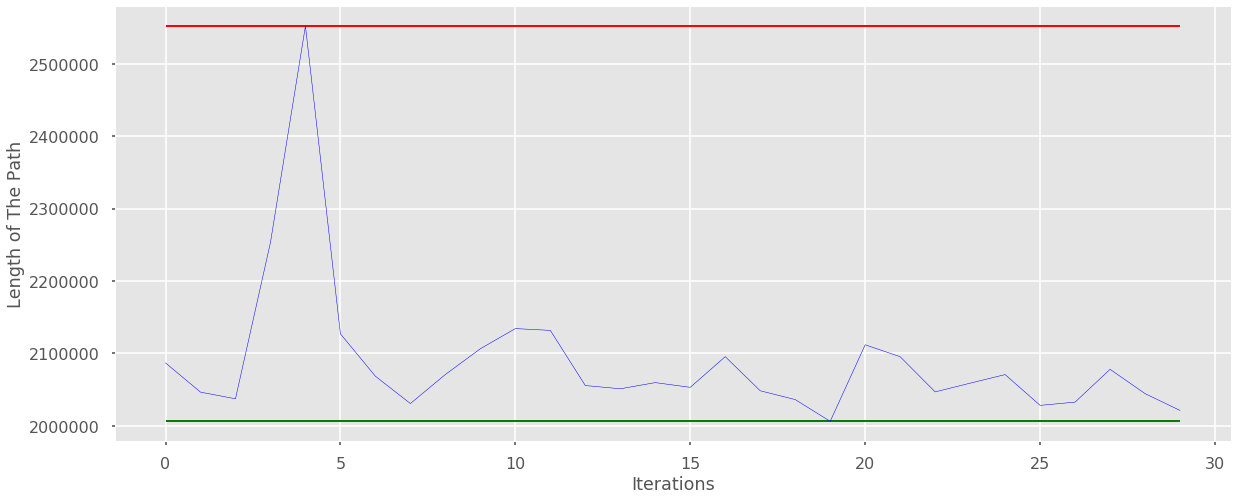

In [16]:
# the following plot shows length of path of each iteration run. 

all_distances = route.drop_duplicates('iteration').sort_values(by='iteration')['distance'].values
random_routes = route.sort_values(by='distance', ascending=False)['iteration'].unique()[:5]
shortest_route = shortest_route.loc[: , ['visitOrder', 'lng', 'lat']]
shortest_route.rename(columns={'visitOrder': 'order'}, inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,8))
ax.plot([_ for _ in all_distances], color='blue', linewidth=0.5)
ax.hlines(y=min([_ for _ in all_distances]), xmin=0, xmax=n-1, color='green', linewidth=2)
ax.hlines(y=max([_ for _ in all_distances]), xmin=0, xmax=n-1, color='red', linewidth=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('Length of The Path');

print(f"[Min] {min([_ for _ in all_distances])};  [Max] {max([_ for _ in all_distances])}")

In [17]:
sa_shortest_route = pd.DataFrame([LineString((shortest_route.values[i-1][1:][::-1], 
                                              shortest_route.values[i][1:][::-1])) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route = sa_shortest_route.append(pd.DataFrame([LineString((shortest_route.values[-1][1:][::-1], shortest_route.values[0][1:][::-1]))], columns=['geometry']))
sa_shortest_route['order'] = sa_shortest_route.index + 1

sa_shortest_route_origin = pd.DataFrame([Point(shortest_route.values[i-1][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_origin = sa_shortest_route_origin.append(pd.DataFrame([Point(shortest_route.values[-1][1:][::-1])], columns=['geometry']))
sa_shortest_route_origin['order'] = sa_shortest_route_origin.index + 1

sa_shortest_route_dst = pd.DataFrame([Point(shortest_route.values[i][1:][::-1]) 
                                  for i in range(1, len(shortest_route.values))], columns=['geometry'])
sa_shortest_route_dst = sa_shortest_route_dst.append(pd.DataFrame([Point(shortest_route.values[0][1:][::-1])], columns=['geometry']))
sa_shortest_route_dst['order'] = sa_shortest_route_dst.index + 1

Map(layers=[
    Layer(sa_shortest_route_origin,
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(sa_shortest_route_dst,
         geom_col = 'geometry',
         style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(sa_shortest_route, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'))
    ],
    basemap = basemaps.voyager)

<br/>

### Method 3: **Ant Colony Optimization**

In [18]:
# alpha: relative importance of pheromone
# beta: relative importance of heuristic information
# rho: pheromone residual coefficient
# q: pheromone intensity
# strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density

aco = ACO(ant_count=200, generations=100, alpha=1.0, beta=10.0, rho=0.75, q=10, strategy=3)

cost_matrix = distance_aco(latlng_dict)
rank = len(latlng_dict)
graph = Graph(cost_matrix, rank)
path, cost = aco.solve(graph)

[Done] Create A Distance Matrix For ACO
[Done] Load the Graph
[Generation #0] [best cost: 2181608.7485692617]
[Generation #1] [best cost: 2171100.121573765]
[Generation #2] [best cost: 2171100.121573765]
[Generation #3] [best cost: 2127318.9163895883]
[Generation #4] [best cost: 2091389.5954935802]
[Generation #5] [best cost: 2091389.5954935802]
[Generation #6] [best cost: 2091389.5954935802]
[Generation #7] [best cost: 2091389.5954935802]
[Generation #8] [best cost: 2091389.5954935802]
[Generation #9] [best cost: 2087301.2929845161]
[Generation #10] [best cost: 2087301.2929845161]
[Generation #11] [best cost: 2087301.2929845161]
[Generation #12] [best cost: 2087301.2929845161]
[Generation #13] [best cost: 2087301.2929845161]
[Generation #14] [best cost: 2087301.2929845161]
[Generation #15] [best cost: 2062269.323016456]
[Generation #16] [best cost: 2062269.323016456]
[Generation #17] [best cost: 2062269.323016456]
[Generation #18] [best cost: 2062269.323016456]
[Generation #19] [best 

In [19]:
print(f'[Done] Cost: {cost}\nPath: {path}')

[Done] Cost: 2043609.523111836
Path: [67, 70, 54, 55, 66, 57, 6, 40, 12, 69, 13, 0, 60, 44, 62, 19, 4, 22, 20, 65, 31, 2, 45, 14, 47, 43, 28, 35, 50, 34, 46, 33, 51, 24, 52, 64, 5, 25, 39, 63, 61, 23, 42, 48, 53, 38, 37, 21, 9, 30, 17, 7, 1, 59, 11, 36, 3, 18, 58, 72, 15, 8, 10, 41, 16, 29, 32, 68, 27, 71, 26, 56, 49]


In [20]:
loop = path.copy()
loop.append(loop[0])

ac_shortest_route = pd.DataFrame([LineString((lnglat[loop[i-1]], lnglat[loop[i]])) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route['order'] = ac_shortest_route.index + 1
ac_shortest_route_origin = pd.DataFrame([Point(lnglat[loop[i-1]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_origin['order'] = ac_shortest_route_origin.index + 1
ac_shortest_route_dst = pd.DataFrame([Point(lnglat[loop[i]]) for i in range(1, len(loop))], columns=['geometry'])
ac_shortest_route_dst['order'] = ac_shortest_route_dst.index + 1

Map(layers=[
    Layer(ac_shortest_route_origin,
          geom_col = 'geometry',
          style = animation_style('order', size = 10, color = '#882255', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(ac_shortest_route_dst,
         geom_col = 'geometry',
         style = animation_style('order', size = 10, color = '#88CCEE', opacity = 1, duration=40, fade_in = 0, fade_out = 0.5)),
    Layer(ac_shortest_route, 
          geom_col = 'geometry',
          style = animation_style('order', size = 3, color = 'red', opacity = 1, duration=40, fade_in = 0, fade_out = 'hold'))
    ],
    basemap = basemaps.voyager)

## **Reference**

- Simulated Annealing: https://github.com/perrygeo/simanneal
- Ant Colony Optimization: https://github.com/ppoffice/ant-colony-tsp
- Christofides Algorithm: https://github.com/Retsediv/ChristofidesAlgorithm